In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

Undrift!

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
  7.0
 -3.0
  0.5217585911678171
 -7.258853704790459
 -0.3132345314884415
 -8.345010264987645
  4.040886054078711
 -7.4369155981293185
 -1.8544374190398407
  0.846203862555444
  ⋮
 11.554463255669031
  6.429313000236826
  0.794984500072796
  1.344847829057541
  6.970983483805899
  2.1631202433784384
  3.650705743112443
 -3.8834354232276835
 10.391821807214532

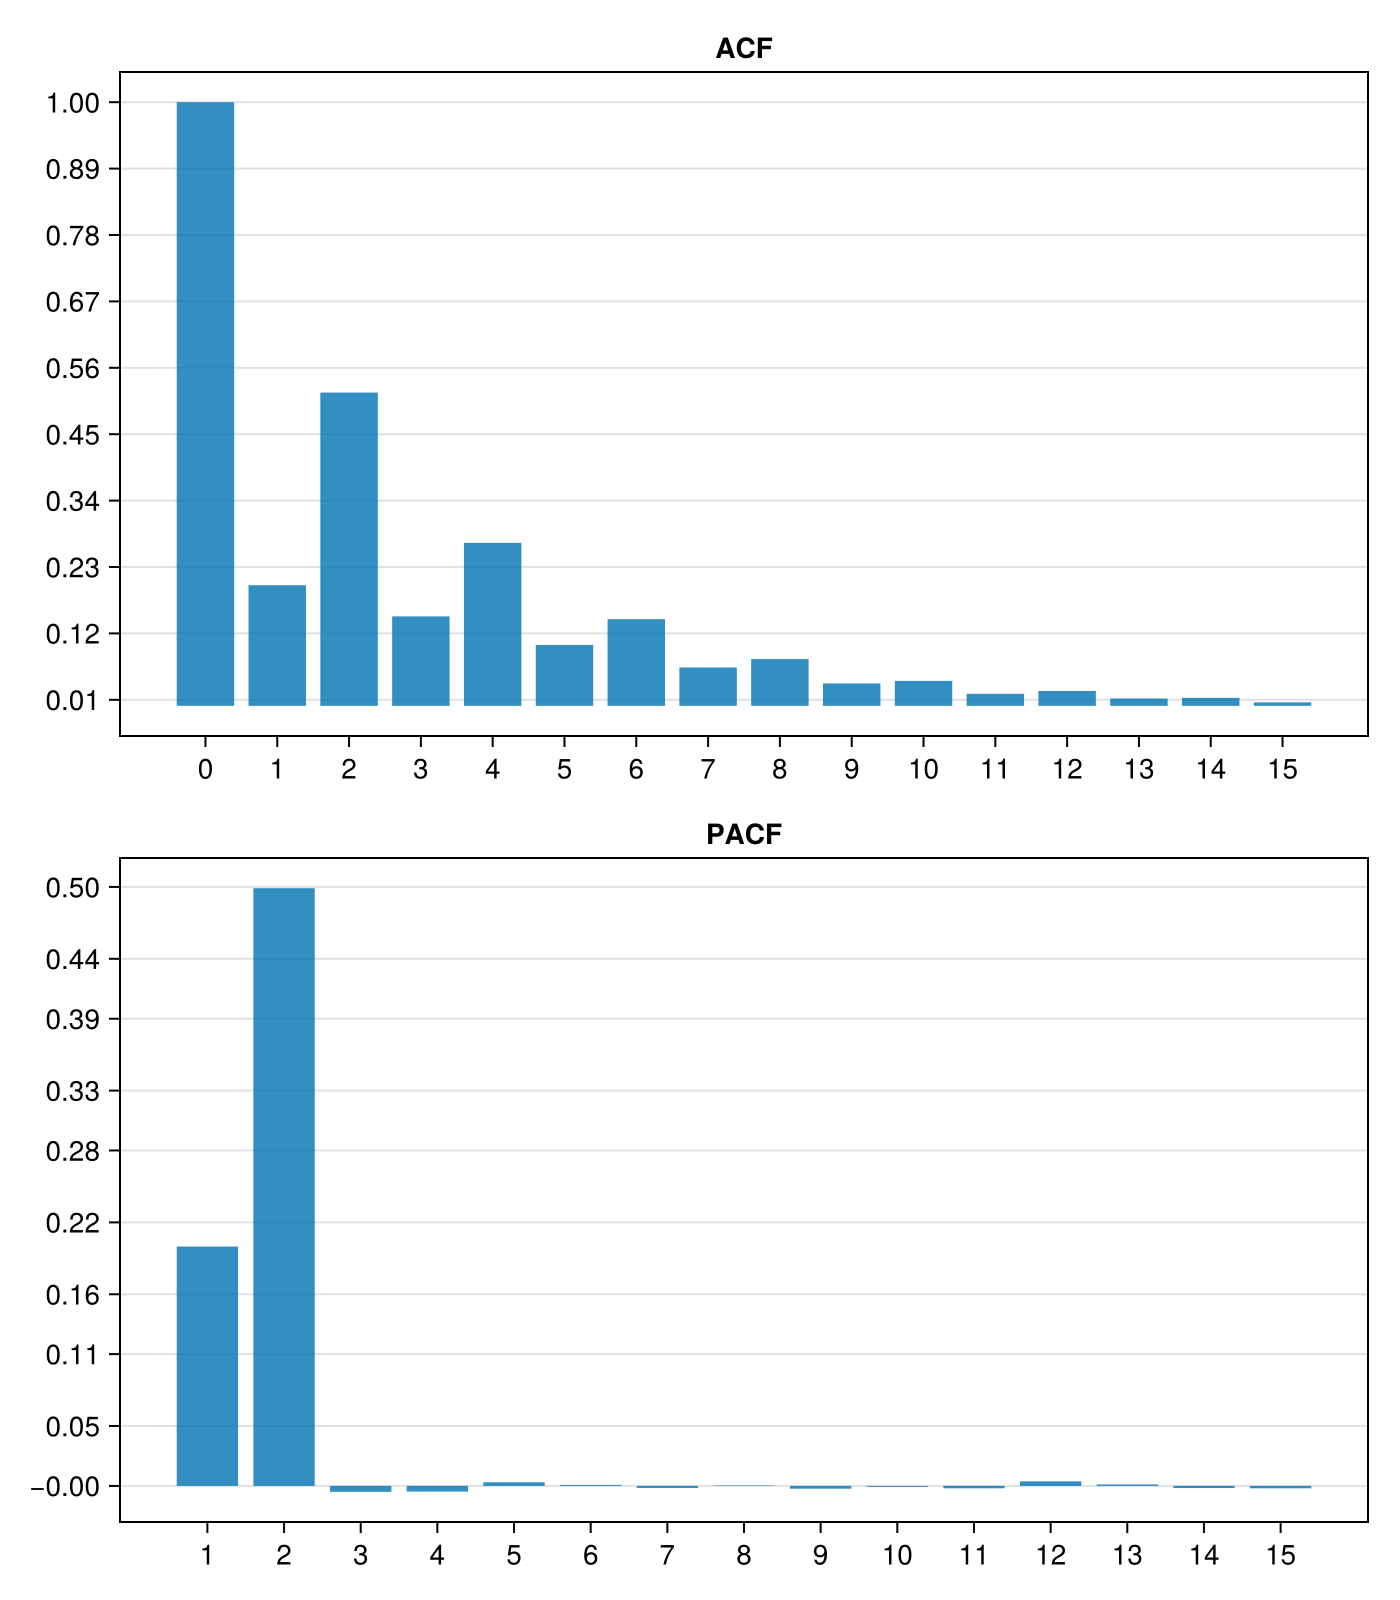

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.000198913,0.00198913
2,Φ₂,0.000959123,0.00191825
3,σ,0.0360951,0.00601585


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

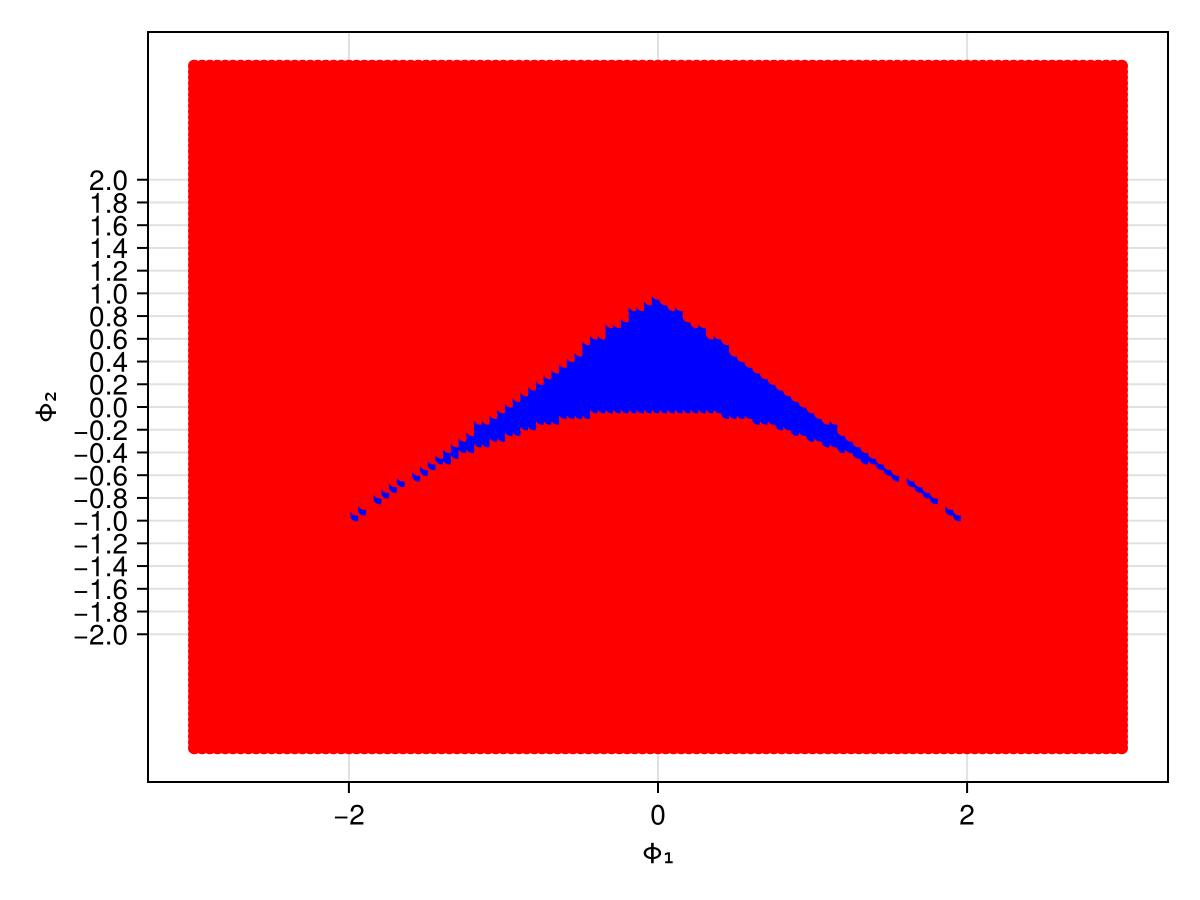

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[-11.830493503778309, -8.867875840642286, -5.731368117549229, -4.297462367958133, -2.5298901484727443, -1.9343221545411118, -1.3167730825795585, -1.5368776701262088, -0.3016325674463751, -1.4444748584814282  …  -1.1774787358488874, 1.8157871227242848, 1.74613731979926, 2.0307062207934745, -0.0617527891473133, 0.3959352846350299, 0.5767354983890429, 0.11210777859006205, 0.23233985976467278, 1.5175798442612844], [6.387804540576672, 4.171627279071305, 1.921901982442947, 0.6283777278636054, -1.6406111362835591, 1.2574513373307046, -1.206641429022806, 1.7036169232314082, 3.992688644119428, 2.895690049073098  …  -4.00579890063087, -2.6870719322992724, -2.3467610613340217, -1.2291631589927103, -1.423719246834997, 0.7571911252356419, 0.39305721896319723, -0.39307695486904937, 0.8347404227857065, 0.48200935801260886], [8.77328083593449, 6.413198651485958, 4.93849320427971, 4.153170746159218, 0.22349862972344825, 1.4813205185888314, 1.174514563223542,

## Autocorrelations

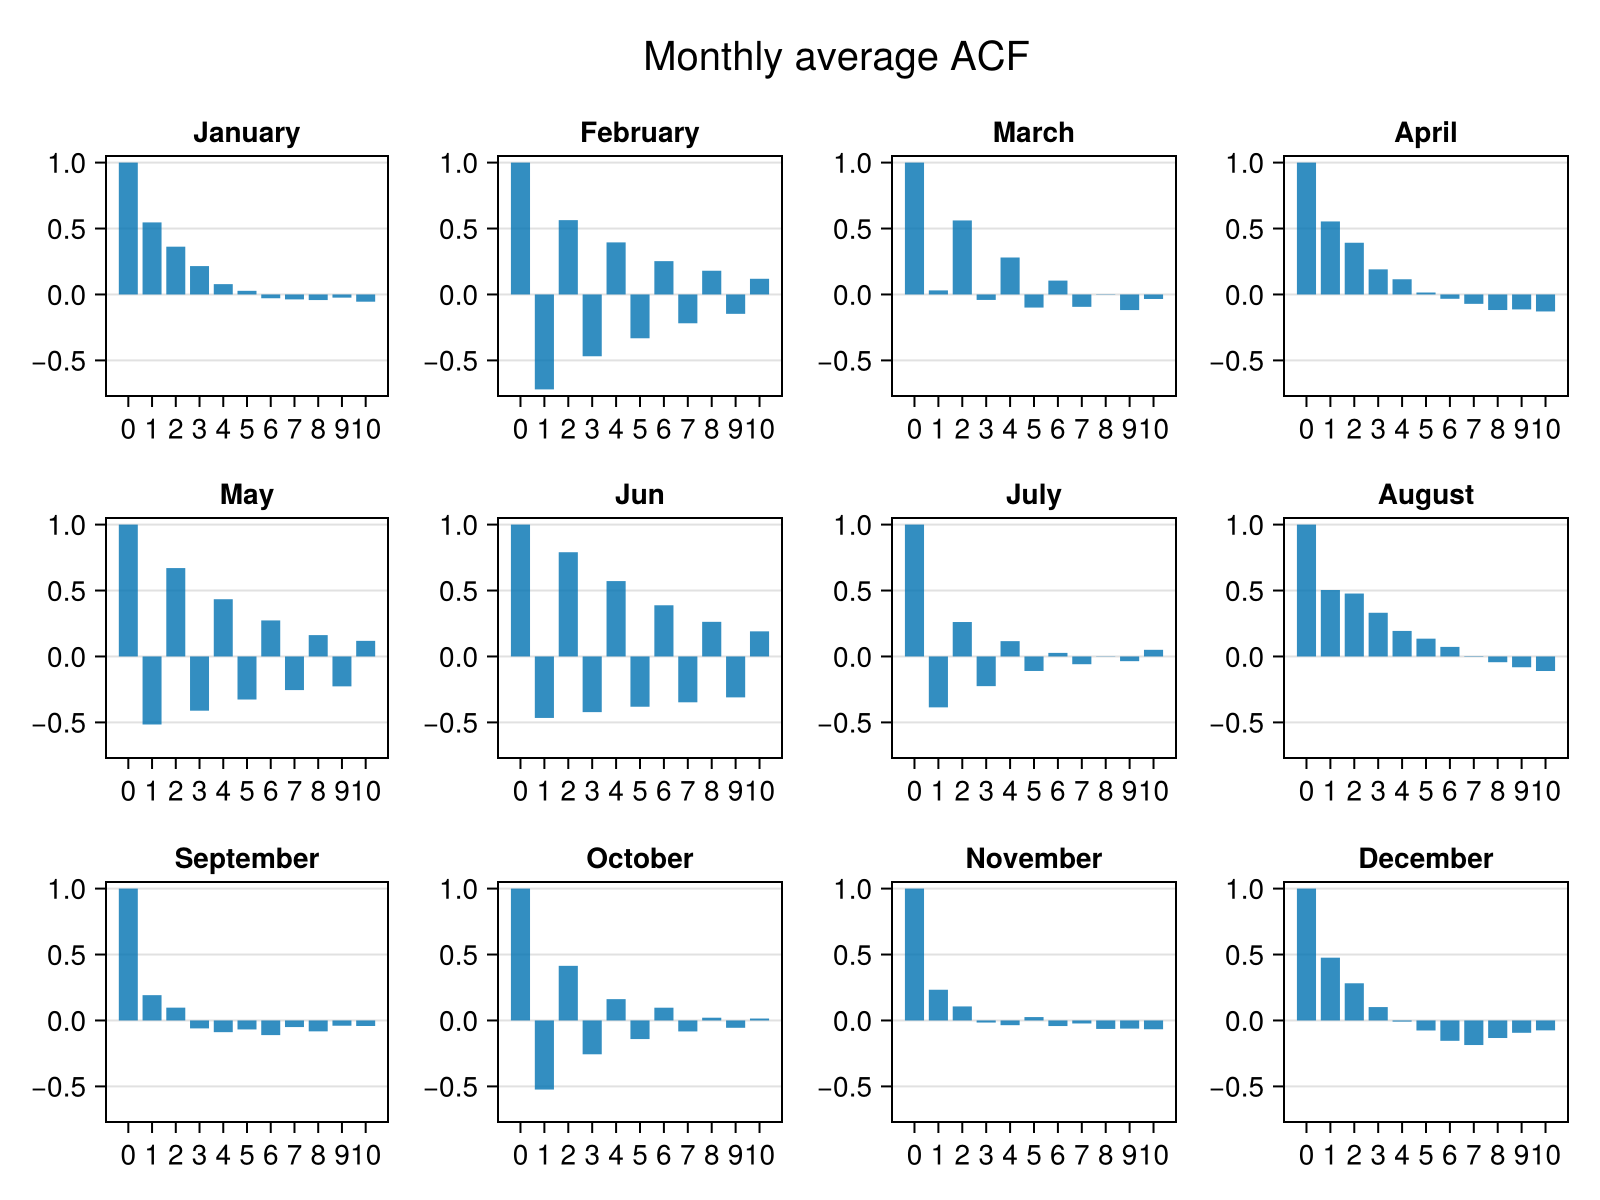

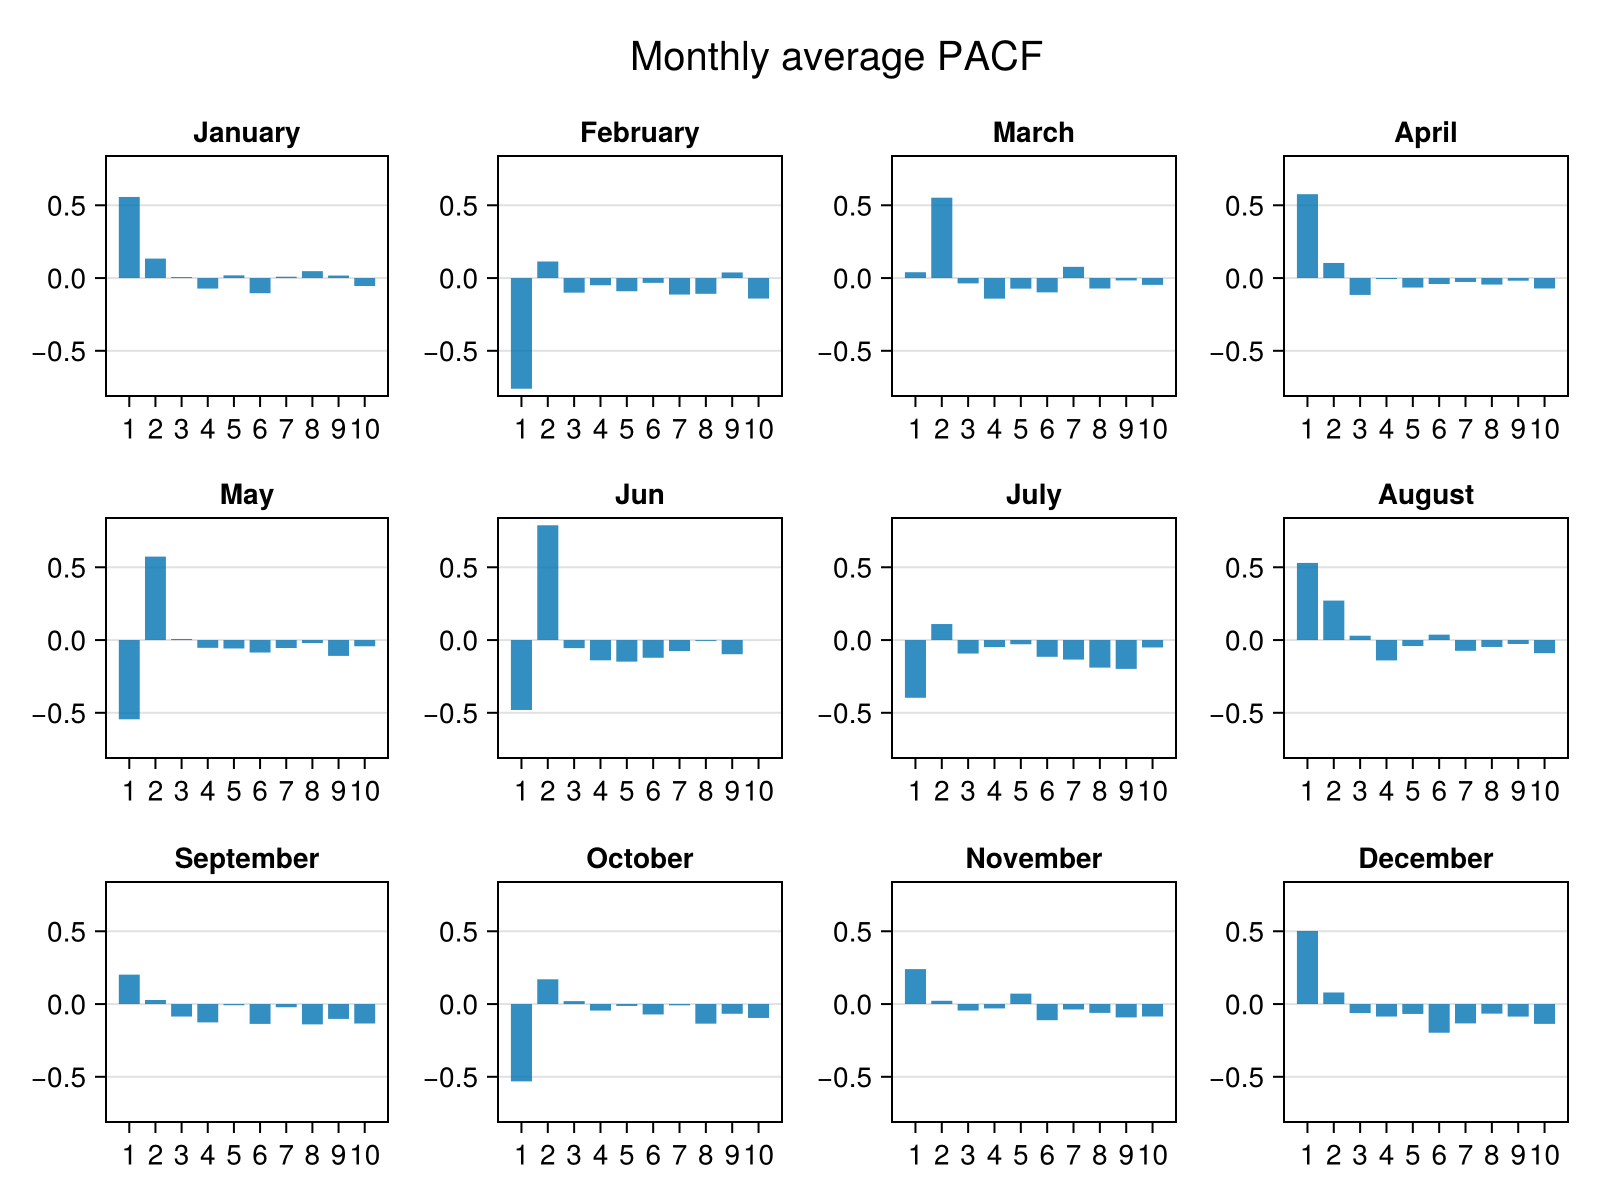

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

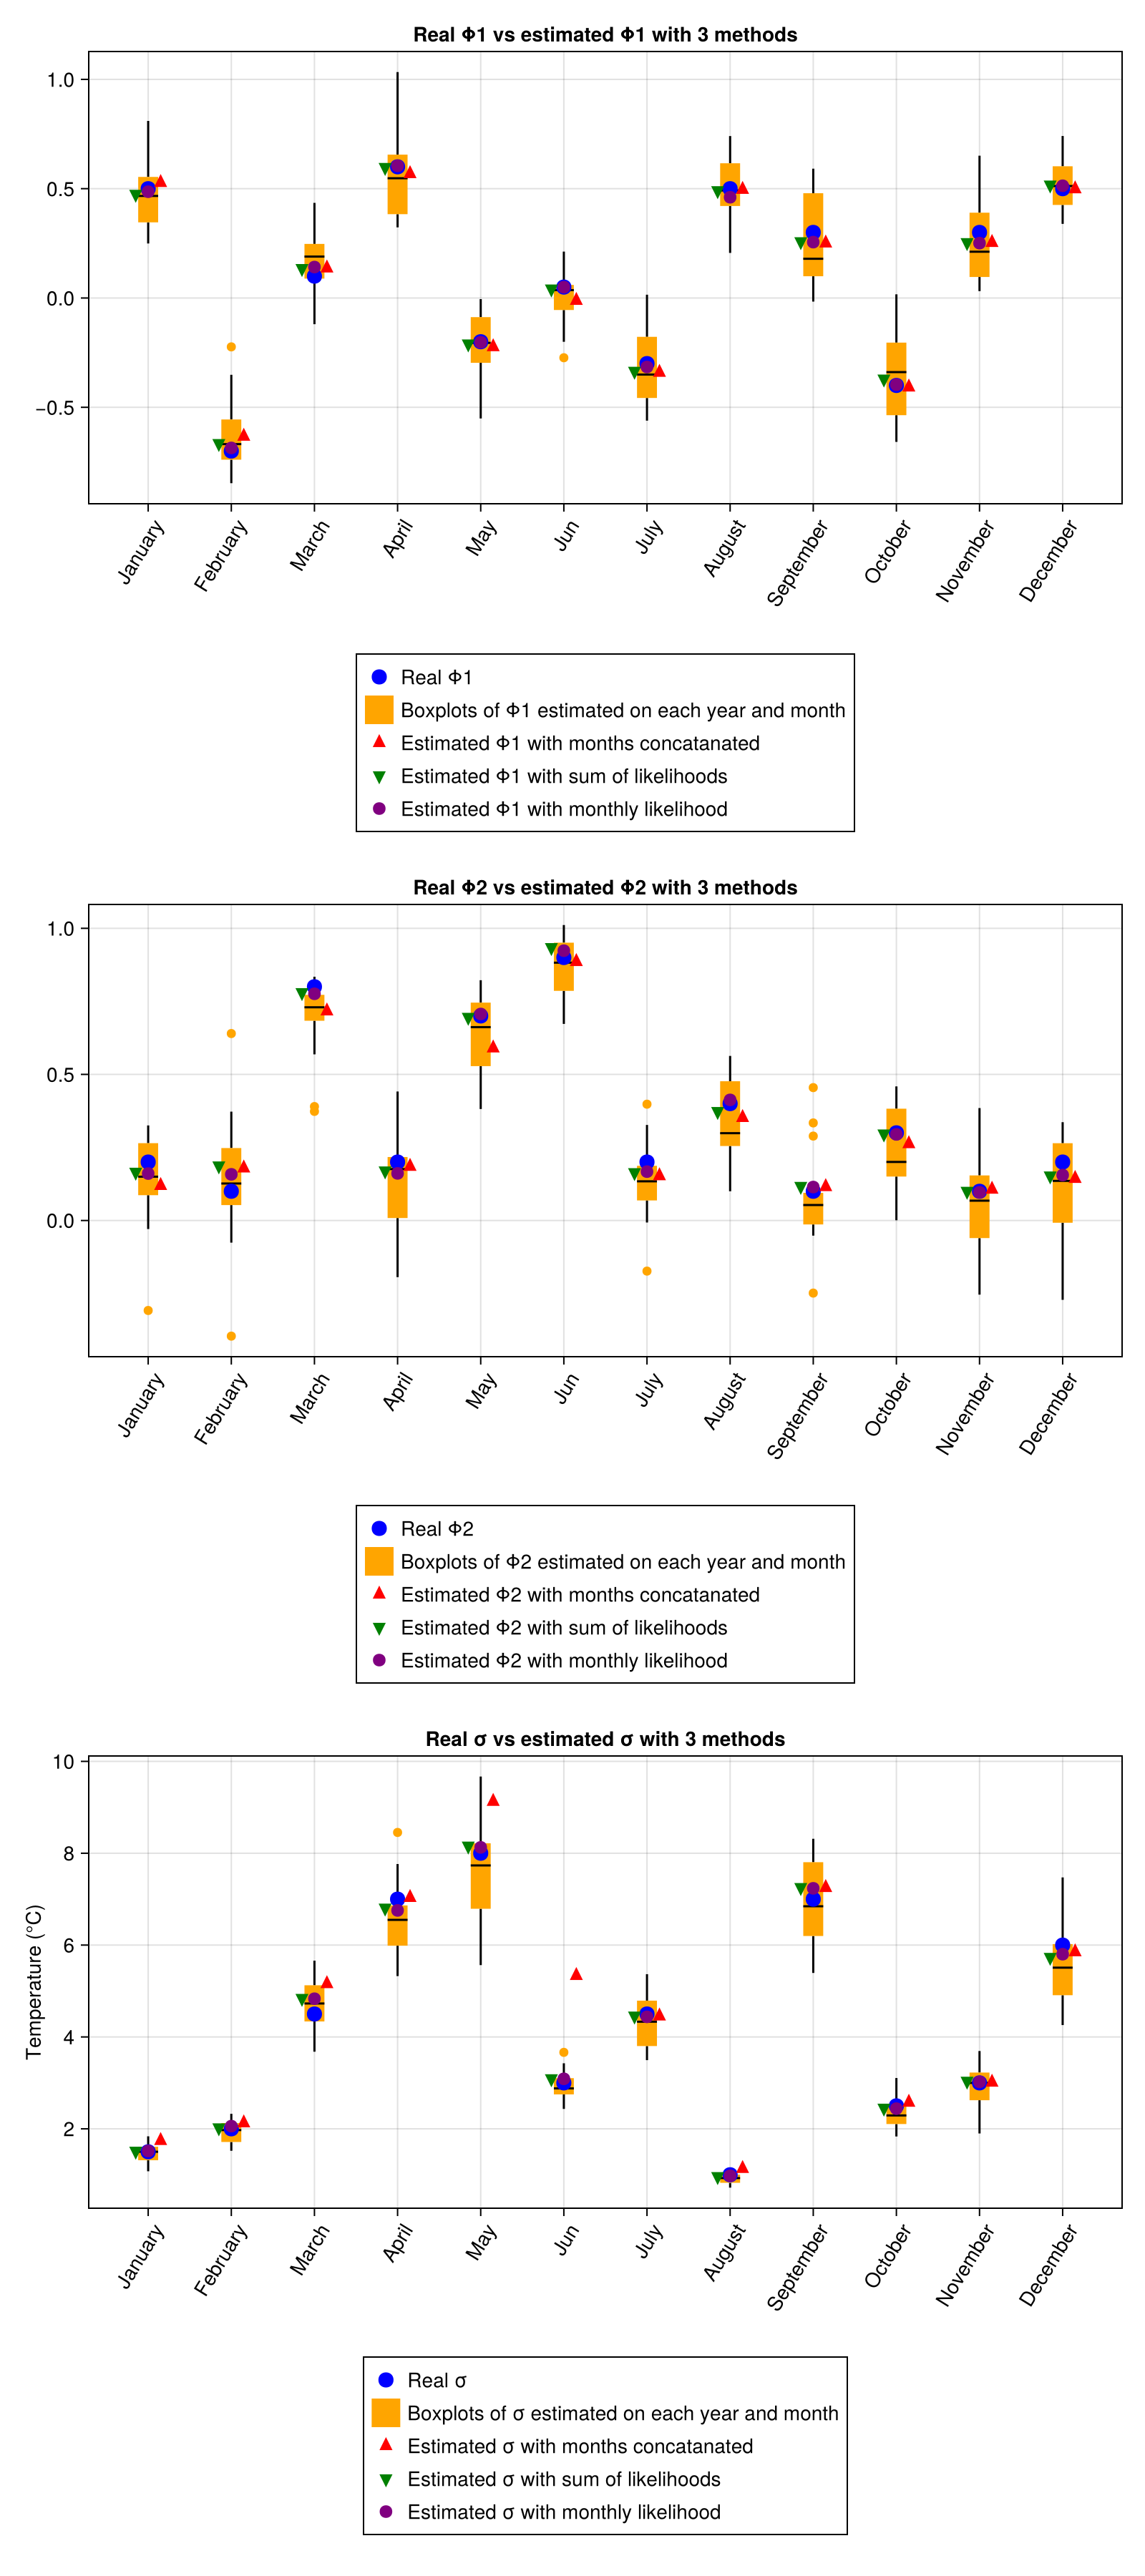

Row,Parameter,Month concatanation,Sum LL,Monthly LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64,Float64
1,Φ1,20.0469,10.0293,8.08288,18.9363,20.4412
2,Φ2,21.1157,16.0821,13.7638,25.8911,23.5724
3,σ,12.7806,2.8015,2.75294,4.07218,4.16544


7

In [12]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month],ErrorTable=true)
display(autofig)
display(ErrorTable)

In [13]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=10
sim=SimulateScenarios([4.,3.],Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)),Φ_vec, σ_vec,n=10)
sample_=GatherYearScenarios(sim,Date(2001,1,1):(Date(2001,1,1) + Year(n_years-1)))

366-element Vector{Vector{AbstractFloat}}:
 [4.0, 7.282029799944692, -6.2331309730596285, -2.019705843620245, -2.4485841389512846, 3.8881808619758553, 4.309340933351461, 2.313547591722666, -6.855098322658819, -9.385573366946403  …  4.0, 2.682642381423449, 4.529405385280641, -5.5481605189141066, 5.559272865684986, -1.6579624585624806, 3.6181877691485806, -4.593580130970193, -0.24754401522009006, -2.9917706373099917]
 [3.0, 7.488507905728797, -2.618583281407319, -2.6479209993649, -2.9275089023600613, 5.618004306044601, 2.0820534169317906, 3.6859184417972335, -5.351148294027498, 3.0  …  1.5948427723021648, 3.0, 2.3611680630117196, 3.0122792442396036, -2.4888232252243236, -0.6420810925468192, -0.2579544222226309, 4.211338976357209, -5.017727477774294, 1.5790057258636145]
 [1.561780301823579, 3.487448216459973, -4.406326706706347, -1.129982742121936, -2.254943937516074, 5.194566920361712, -0.9331667439976852, -0.5088453725688407, -1.3814148111964646, 4.9506387193697545  …  0.029265076143167

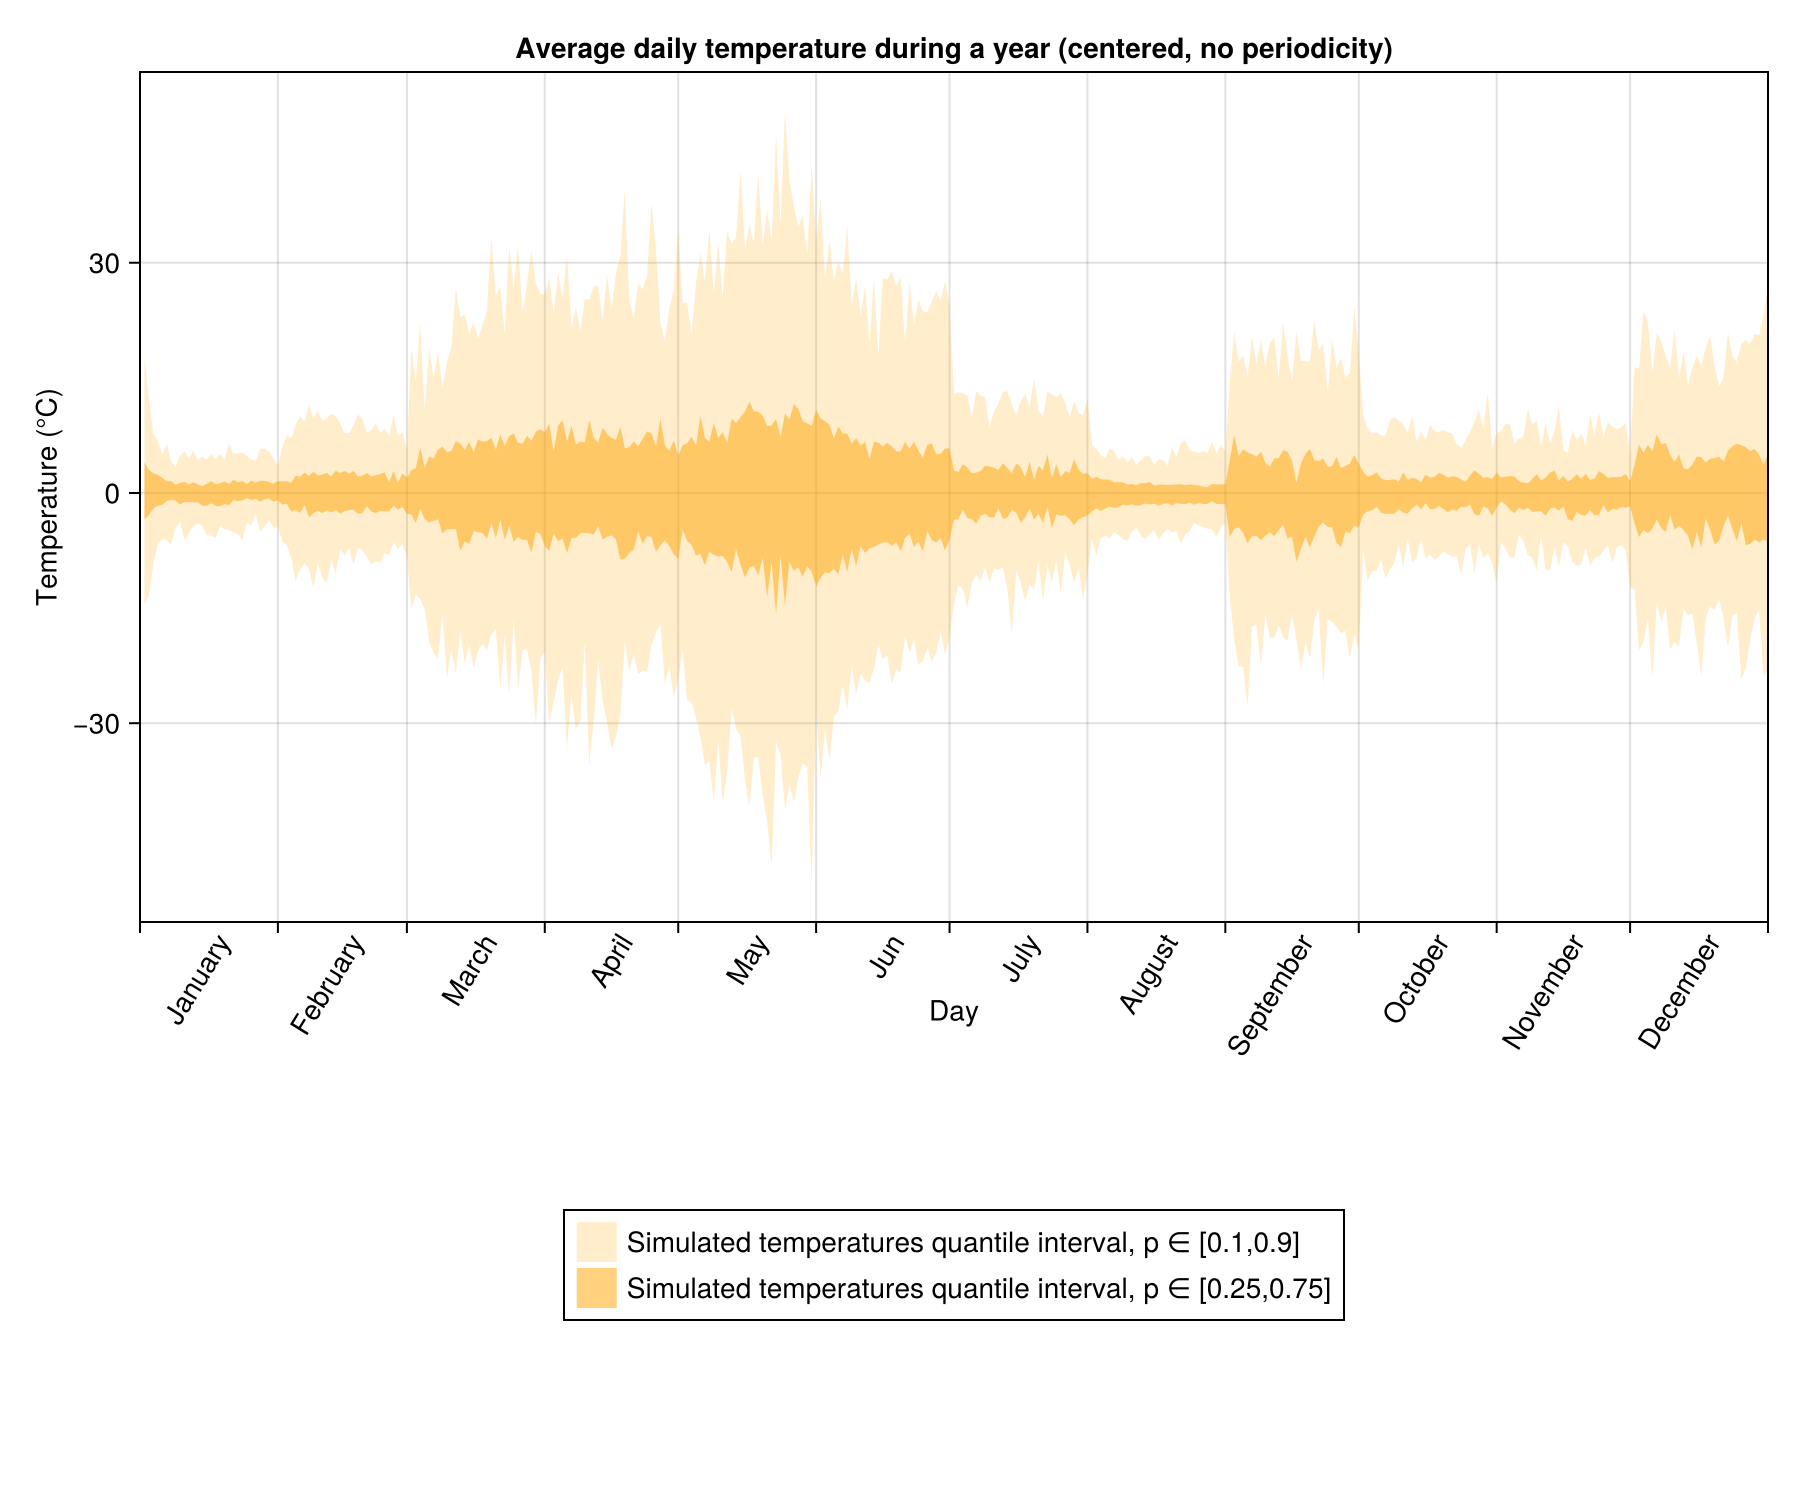

In [14]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(minimum.(sample_),maximum.(sample_)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)